This notebook presents step by step implementation of a binary classifier for MNIST dataset, where we distinguish following classes(digits 0 and 1 are supposed to be removed from the dataset):
- class 0: Prime nubmers(2,3,5,7)
- class 1: Compound numbers(4,6,8,9)

The solution is going to:
 - Implement both **logistic regression** and optimization ***SGD + momentum*** using **numpy**.
 - Tune the hyperparameters in order to increase the performance on test set.
 - Evaluate the model.



***Requirements:***
- python-mnist (Data reader)
- matplotlib
- seaborn
- numpy
- sklearn (for validation purposes only)

***Download MNIST***

(train set):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
 
(test set):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

***Unpack the data and rename the files***

 replace "." to "-" for all of the files names:  
   - **train-images.idx3-ubyte**   ->  **train-images-idx3-ubyte**  
   - **train-labels.idx1-ubyte**   ->  **train-labels-idx1-ubyte**  
   - **10k-images.idx3-ubyte.gz**   ->  **10k-images-idx3-ubyte.gz**  
   - **10k-labels.idx1-ubyte.gz**   ->  **10k-labels-idx1-ubyte.gz**  



***Let's start by importing the necessary libraries***

In [286]:
#Imports
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
%config IPCompleter.greedy=True

#Data
mndata = MNIST('C:/Users/45502/my_notebooks')  #input valid path pointing unpacked and renamed MNIST dataset 

# function: process_data
This function will process the data so that it is ready to be feed to the [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)  
SGD is an optimization algorithm. In this project it will optimize [logistic regression cost function](https://www.coursera.org/lecture/machine-learning/cost-function-1XG8G)  
SGD is going to set the values of the parameters Theta(see the README.md) so that the error of our model is the lowest.
* First it will transform the MNIST dataset so that we have only two classes - prime and compound numbers.  
* Then it will append a column of ones to the input data so that the [intercept term](https://stats.stackexchange.com/questions/92903/intercept-term-in-logistic-regression) can be calculated.
* Lastly it will [normalize](https://en.wikipedia.org/wiki/Normalization_(statistics)) the data set.

*NOTE: Understanding this function is not crucial for this project* 

In [287]:
def process_data(train_imgs: list, train_labels: list, test_imgs: list,
                 test_labels: list, train_size: list, test_size: list):
    
    """
    Method processing the MNIST dataset:
    
    Part 1. Remove all the images of 0 and 1 from both data sets.
    Part 2. Change the label of prime of numbers (2,3,5,7) to 0.
    Part 3. Change the label of compound numbers (4,6,8,9) to 1.
    Part 4. Substract a subest of train set and test set using [train_size] and [test_size]
    Part 5. In order for Logistic regression to work it is neccessary to add an intercept term 
    Part 6. Normalize the data set
    
    Parameters:
    
    train_imgs, train_labels : Train sets data to be processed
    test_imgs, test_labels : Test sets data to be processed
    train_size : number of samples to take from the train set (train_size = 1000, take first 1000 samples from the train set)
        if train_size = None, method returns all of the samples
    test_size : number of samples in the test set, someti
        if train_size = None, method returns all of the samples
    
    Returns:
    
    X (np.array) : processed train_imgs
    y (np.array) : processed train_labels
    test_X (np.array) : processed test_imgs
    test_y (np.array) : processed test_labels
    
    """
    #Part one

    prime_nums = [2,3,5,7]

    #Remove 0 from train data
    train_zero_indicies= [index for index, element in enumerate(train_labels) if element == 0]
    for index in sorted(train_zero_indicies, reverse=True):
        del train_imgs[index]
        del train_labels[index]

    #Remove 0 from test data
    test_zero_indicies= [index for index, element in enumerate(test_labels) if element == 0]
    for index in sorted(test_zero_indicies, reverse=True):
        del test_imgs[index]
        del test_labels[index]

    #Remove 1 from train data
    train_one_indicies= [index for index, element in enumerate(train_labels) if element == 1]
    for index in sorted(train_one_indicies, reverse=True):
        del train_imgs[index]
        del train_labels[index]

    #Remove 1 from test data
    test_one_indicies= [index for index, element in enumerate(test_labels) if element == 1]
    for index in sorted(test_one_indicies, reverse=True):
        del test_imgs[index]
        del test_labels[index]

    #Part 2 and 3
    
    #Separation between 0 - prime numbers and  1 - compound numbers of the train set labels
    for index,val  in enumerate (train_labels):
        if val in prime_nums:
            train_labels[index] = 0
        else:
            train_labels[index] = 1
    
    #Separation between 0 - prime numbers and  1 - compound numbers of the test set labels
    for index,val  in enumerate (test_labels):
        if val in prime_nums:
            test_labels[index] = 0
        else:
            test_labels[index] = 1


    #Part 4
    
    #Convert to numpy
    X = np.array (train_imgs)
    y = np.array (train_labels)
    y = y.reshape((y.shape[0],1))  # reshape the array from shape(m,) to shape(m,1)

    test_X =  np.array(test_imgs)
    test_y = np.array(test_labels)
    test_y = test_y.reshape((test_y.shape[0],1)) # reshape the array from shape(m,) to shape(m,1)
    
    #If not None -> Takes train_size number of samples from the train set
    if train_size != None:
        X=X[:train_size]
        y=y[:train_size] 
    
   #If not None -> Takes train_size number of samples from the test set
    if test_size != None:
        test_X=test_X[:test_size]
        test_y=test_y[:test_size]


    
    #Number of samples for given dataset
    m = len(y)
    test_m = len(test_y)
    
    #Part 5

    #Adding intercept term
    X = np.hstack((np.zeros((m,1)),X))
    print(f"the shape of the X is with the intercept term is {X.shape}")

    test_X = np.hstack((np.zeros((test_m,1)),test_X))

    n = np.size(X,1)
    
    
    #Part 6
    
    #Normalization
    X = (X - np.min(X)) / ((np.max(X) - np.min(X)))
    test_X = (test_X - np.min(test_X)) / (np.max(test_X) - np.min(test_X))
    
    return X, y, test_X, test_y

# Class: Model
This class is responsible for training and predicting the class.


In [288]:
class Model:
    """
    Logistic regression model
    
    Class that is going to predict the label of our classs after having train the parameters
    
    Attributes:
    params - parameters Theta of the function solving our problem
    learning_rate - the learning rate of Stochastic Gradient Descent
    momentum_rate - the momentum rate of  Stochastic Gradient Descent
    """
    
    params = None
    
    def __init__(self, learning_rate: float, momentum_rate: float):
        
        ''' 
        Init fucntion setting learning rate and momentum of the model object
        
        Parameters:
        learning_rate: the value of the learning rate
        momentum_rate: the value of the momentum rate
        
        '''
        
        self.learning_rate = learning_rate
        self.momentum_rate = momentum_rate
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        '''function to train the model and set the parameters of the fucntion to the ones returned from SGD'''
        
        iterations = X.shape[0] * 8
        include_cost = False
        plot_precision = 0
        self.params = SGD(X, y, None, None, self.learning_rate, self.momentum_rate, iterations,
                          include_cost, plot_precision,True)[2]

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''Predict the label of the class
        
        Returns:
        predicted labels
        
        '''
        pred = sigmoid(X@self.params)
        pred = pred>=0.5
        
        return pred.astype(int)
    

    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        ''' 
        Evalutes the predicted classes
        Returns:
        accuracy: accuracy of the model
        '''
        errors_num =  np.sum(y_true != y_pred)
        accuracy =  1 - errors_num / y_true.shape[0] 
        return accuracy


**In logistic regression the predictive function _h_ is defined as**   
_h = sigmoid(X*theta)_  
**The cost function _J_ that global minimum** 
J = (sum ( ( -y .* log(h)) - ((1-y) .*(log(1-h) )) ) ) /m;
sum()

In [289]:
def sigmoid(z: float):
    """
    Calculates sigmoid of z
    
    Returns:
    sigmoid of z
    
    """
    
    return 1 / ( 1 + np.exp(-z) )


def compute_cost(X: np.array, y: np.array, theta: np.array):
    '''
    Calucaltes the cost of the function
    
    Returns:
    Cost of the function
    
    '''
    
    m = X.shape[0]
    #print(f'the m is equal to {m}')
    h = sigmoid(X @ theta)
    cost = - np.average(y * np.log(h) + (1 - y) * np.log(1 - h))
    
    return cost

In [290]:
def SGD(X: np.array, y: np.array, test_X: np.array, test_y: np.array, learning_rate: float, momentum_rate: float,
                 iterations: int, include_cost: bool, cost_precision: int, bias_correction):
    '''
    Stochasit gradient descent

    Optimization of the parameters in order to find the min cost of the function

    Parameters:
    X (np.array) : train data
    y (np.array) : train labels
    test_X (np.array) : test data
    test_y (np.array) : test labels
    learning_rate: the value of the learning rate
    momentum_rate: the value of the momentum rate
    
    Returns:
    test_cost_history: cost history of the test set 
    train_cost_history: cost history of the train set
    params: best function parameters for min cost
    '''
    
    # cost history and samples num initialization
    test_cost_history = np.zeros((iterations,1))
    train_cost_history = np.zeros((iterations,1))
    m = len(y)
    n = np.size(X,1)
    this_velocity = np.zeros((n,1))
    
    params =  np.zeros((n,1))/4
    
    for i in range(iterations):
        
        #TODO: add decaying learning rate
        
        #Bias correction        
        if bias_correction:
            ''' early stage bias reduction for momentum'''
            bias_correct = 1 - (momentum_rate**(i+1) )
        else:
            bias_correct =  1

        #Reset index after each epoch
        sample_index = i%m
        
        #Sample extraction
        current_X = X[sample_index].reshape((1,X.shape[1]))
        current_y = y[sample_index]
        
        #Inference for current parameters
        h =sigmoid(current_X@params)
        
        #Gradient
        grad = learning_rate* (current_X.T @  (h- current_y) )
        
        #Update momentum only for 50 iterations
        if i <= 50:
            this_velocity = momentum_rate *  this_velocity + grad 
        else:
            this_velocity = grad
        
        this_velocity = this_velocity * (1/ bias_correct)

        #Update params
        params -= this_velocity 
        
        #Cost for current parameters
        if include_cost:
            #For big dataset we will save every cost_precision
            if i %cost_precision == 0:
                test_cost_history[i] = compute_cost(test_X, test_y, params)
                train_cost_history[i] = compute_cost(X, y, params)
            else:
                test_cost_history[i] = test_cost_history[i-1]
                train_cost_history[i] =  train_cost_history[i-1]

    return (test_cost_history, train_cost_history, params)

In [295]:
def hyperparameters_tunning(iterations: int, X: np.array, y: np.array, test_X, test_y, initial_lr: float, steps_lr: int,
                            delta_lr: float, initial_mr: float, steps_mr: int, delta_mr: float, visualize: bool):
    '''
    Circulates around the initial learning rate and momementum rate in order to find their best values.
    
    Function changes its values by delta_lr/mr and does it steps_lr/mr times.
    
    Parameters:
    X (np.array) : train data
    y (np.array) : train labels
    test_X (np.array) : test data
    test_y (np.array) : test labels
    initial_lr: the initial learning rate
    steps_lr: number of iterations learning rate
    delta_lr: change of the learning rate per iteration
    initial_mr: the initial momentum rate
    steps_mr: number of iterations momentum rate
    delta_mr: change of the momentum rate per iteration
    visualize: whether to plot the graph or not
    
    Returns:
    hyper_parameters_cost_results: history of all of the costs
    min_cost: minimal cost
    best_lr: the best learning rate
    best_mr: the best momentum rate
    '''
    min_cost = 1000
    best_lr = None
    best_mr = None
    n  = np.size(X,1)
    #History inside the SGD and its iterations
    include_cost_history=False
    hyper_parameters_cost_results = np.ones((steps_lr,steps_mr))
    
    for learning_iter in range(steps_lr):
        learning_rate = initial_lr + learning_iter*delta_lr
        
        for momentum_iter in range(steps_mr):
            momentum_rate = initial_mr - momentum_iter * delta_mr
            print (f'momentum rate {momentum_rate}')
            params_optimal =  SGD(X, y, test_X, test_y, learning_rate, momentum_rate,
                                                                       iterations, include_cost_history, 0, True)[2]
            test_final_cost = compute_cost(test_X, test_y, params_optimal)
            print(f'test final cost is {test_final_cost}')
            if test_final_cost < min_cost:
                min_cost = test_final_cost
                best_lr = learning_rate
                best_mr = momentum_rate
            
            hyper_parameters_cost_results[learning_iter,momentum_iter] = test_final_cost
            color = np.random.rand(3,)        
#         if visualize:
#             plt.legend()
#             plt.show()

   
    return hyper_parameters_cost_results, min_cost, best_lr, best_mr

In [296]:
#SGD  momentum tunning
train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()
X, y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, None, None)
print (np.max(X), np.min(X))
print (np.max(test_X), np.min(test_X))
iterations = X.shape[0] * 1 

initial_lr = 0.0065
steps_lr = 10
delta_lr = - 0.00005

initial_mr = 0.9
steps_mr = 10
delta_mr = 0.05

visualize = False
hist,min_cost,lr,mr = hyperparameters_tunning(iterations, X, y, test_X, test_y, initial_lr, steps_lr,
                            delta_lr, initial_mr, steps_mr, delta_mr, visualize)
print ('SGD MOMENTUM')
print ('min cost is', min_cost)
print('best learning rate is',lr)
print('best momentum rate is', mr)

the shape of the X is with the intercept term is (47335, 785)
1.0 0.0
1.0 0.0
momentum rate 0.9


<ipython-input-289-9e7395ede31a>:10: RuntimeWarning: overflow encountered in exp
  return 1 / ( 1 + np.exp(-z) )
<ipython-input-289-9e7395ede31a>:25: RuntimeWarning: divide by zero encountered in log
  cost = - np.average(y * np.log(h) + (1 - y) * np.log(1 - h))
<ipython-input-289-9e7395ede31a>:25: RuntimeWarning: invalid value encountered in multiply
  cost = - np.average(y * np.log(h) + (1 - y) * np.log(1 - h))


test final cost is nan
momentum rate 0.85
test final cost is nan
momentum rate 0.8
test final cost is 0.26091472993309045
momentum rate 0.75
test final cost is 0.25493084772943886
momentum rate 0.7
test final cost is 0.25447300592592925
momentum rate 0.65
test final cost is 0.2543383365739392
momentum rate 0.6
test final cost is 0.2542813004331673
momentum rate 0.55
test final cost is 0.2542504663960583
momentum rate 0.5
test final cost is 0.25423119690117013
momentum rate 0.45
test final cost is 0.25421802654833153
momentum rate 0.9
test final cost is nan
momentum rate 0.85
test final cost is nan
momentum rate 0.8
test final cost is 0.2607540898182841
momentum rate 0.75
test final cost is 0.254846820900678
momentum rate 0.7
test final cost is 0.25439326787494076
momentum rate 0.65
test final cost is 0.25425990069816456
momentum rate 0.6
test final cost is 0.25420337911195273
momentum rate 0.55
test final cost is 0.25417281509201467
momentum rate 0.5
test final cost is 0.25415371501576

In [299]:
#SGD WITHOUT momentum for whole dataset + tunned parameters
train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()
X, y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, None, None)
iterations = X.shape[0] * 8 
lr = 0.00605
mr = 0.45
include_cost_history = False
cost_history_ratio = 0
params_optimal =  SGD(X, y, test_X, test_y, lr, mr,  iterations, include_cost_history, cost_history_ratio, True)[2]
cost =  compute_cost(test_X, test_y, params_optimal)

print("SGD WITHOUT MOMENTUM")
print ('Test set cost for entire test set: ', cost)


the shape of the X is with the intercept term is (47335, 785)
SGD WITHOUT MOMENTUM
Test set cost for entire test set:  0.24988934309181182


In [300]:
#SGD WITH momentum for whole dataset + tunned parameters
train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()
X, y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, None, None)
iterations = X.shape[0] * 8 
lr = 0.00605
mr = 0.45
include_cost_history = False
cost_history_ratio = 0
params_optimal =  SGD(X, y, test_X, test_y, lr, mr,  iterations, include_cost_history, cost_history_ratio, True)[2]
cost =  compute_cost(test_X, test_y, params_optimal)

print("SGD WITH MOMENTUM")
print ('Test set cost for entire test set: ', cost)


the shape of the X is with the intercept term is (47335, 785)
SGD WITH MOMENTUM
Test set cost for entire test set:  0.24988934309181182


The momentum only helps at the begining, after 50 iterations it's turned off, therefore we expect the same values from Momentum/Normal SGD, we can see the difference in the next plot in the speed the converge

In [303]:
#Calculate convergence 


train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()

train_X, train_y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, 5000, 100)
iterations = train_X.shape[0] * 1 # Number of epoches
lr = 0.00605 #Learning reate
mr = 0.45   #Momentum rate
include_cost_history = True
cost_history_ratio = 1 # This will calculate cost for both train and test set every cost_history_iteration

comparison = {}
comparison['regular'] =SGD(train_X, train_y, test_X, test_y, lr, 0,  iterations, include_cost_history, cost_history_ratio, False)
comparison['momentum'] =SGD(train_X, train_y, test_X, test_y, lr, mr,  iterations, include_cost_history, cost_history_ratio, True)




the shape of the X is with the intercept term is (5000, 785)


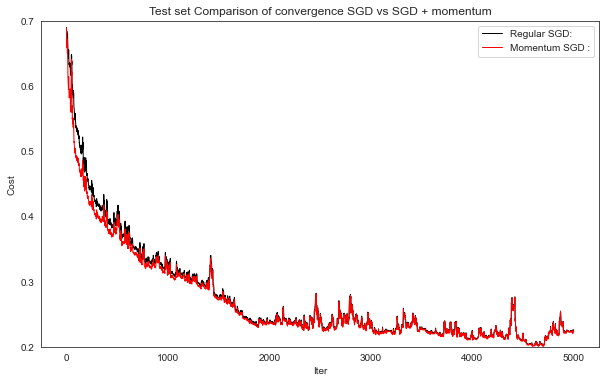

In [306]:
plt.figure(figsize=(10,6))
plt.title('Test set Comparison of convergence SGD vs SGD + momentum')
sns.set_style('white')
plt.xlabel("Iter")
plt.ylabel("Cost")

plt.plot( comparison['regular'][0], 'r',linewidth=1, label="Regular SGD:", color='black' )
plt.plot( comparison['momentum'][0] ,'r',linewidth=1, label="Momentum SGD :", color='red' )

plt.ylim(0.2,0.7)
plt.legend()
plt.show()


Momentum SGD converge sligtly faster at eraly iterations

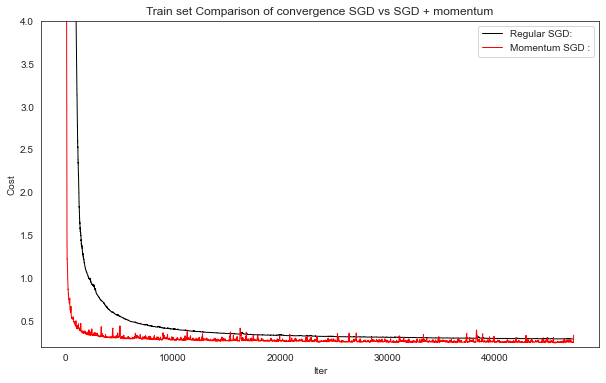

In [20]:
plt.figure(figsize=(10,6))
plt.title('Train set Comparison of convergence SGD vs SGD + momentum')
sns.set_style('white')
plt.xlabel("Iter")
plt.ylabel("Cost")

plt.plot( comparison['regular'][1], 'r',linewidth=1, label="Regular SGD:", color='black' )
plt.plot( comparison['momentum'][1] ,'r',linewidth=1, label="Momentum SGD :", color='red' )

plt.ylim(0.2,4)
plt.legend()
plt.show()


In [ ]:
#Model initialization
LR = Model(0.00605, 0.45)

#Data reading
train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()
X, y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, None, None)

#Train
LR.fit(X,y)

#Evaluation
y_pred = LR.predict(test_X)
acc = LR.evaluate(y_pred,test_y)
print ("Accuracy is :", acc*100, "%")

In [ ]:
#There is not class inbalance in this dataset
from sklearn.metrics import precision_recall_fscore_support
print (precision_recall_fscore_support.__doc__)
precision_recall_fscore_support(test_y, y_pred, average=None)
#print()

In [ ]:
print (sum (test_y == 0))
print (sum (test_y == 1))

In [ ]:
print (sum (y == 0))
print (sum (y == 1))